<a href="https://colab.research.google.com/github/sfarrukhm/genAI/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

100%|██████████| 1.33G/1.33G [00:13<00:00, 104MB/s]

Extracting files...


In [ ]:
import os
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch
from PIL import Image
import torchvision


transform=transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=(0.5),std=(0.5))
    ])

class ImagesWithNoLabels(datasets.ImageFolder):
  def __getitem__(self, index):
    image, _ = super().__getitem__(index)
    return image
dataset=ImagesWithNoLabels(path,transform=transform)



# Dataset lengths
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.2 * len(dataset))  # 20% for validation
test_size = len(dataset) - train_size - valid_size  # Remaining for test

# Split dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
train_dataset[0].shape

torch.Size([3, 64, 64])

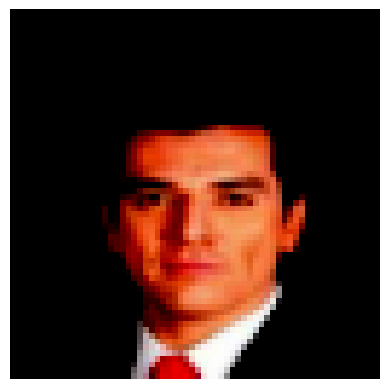

In [ ]:
import matplotlib.pyplot as plt

# Get the image and label (ignore label if unnecessary)
image= dataset[54]  # If using a custom dataset that returns only images, no label will be present

# Show the image using Matplotlib
plt.imshow(image.permute(1, 2, 0))  # Permute channels for matplotlib [C, H, W] -> [H, W, C]
plt.axis('off')
plt.show()


In [44]:
class DCGAN(nn.Module):
  def __init__(self,latent_dim=100 ):
    super().__init__()
    self.discriminator=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Conv2d(64,128,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Conv2d(128,256,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Conv2d(256,512,kernel_size=4,
                  stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Conv2d(512,1,kernel_size=4,
                  stride=2,padding=0,bias=False,),
        nn.Flatten())
    self.generator=nn.Sequential(
        nn.ConvTranspose2d(latent_dim,512, kernel_size=4, stride=1,
                           padding=0,
                               bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(512,256,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(256,128,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),

        nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64,3,kernel_size=4, stride=2, padding=1,
                               bias=False),
        nn.Tanh()
    )
  def generator_forward(self,z):
    generated_image=self.generator(z)
    return generated_image
  def discriminator_forward(self,image):
    logits=self.discriminator(image)
    return logits



from torch.optim import AdamW

model=DCGAN()

optimizer_gener=AdamW(model.generator.parameters(),lr=1e-4,betas=(0.95,0.999),)
optimizer_discr=AdamW(model.discriminator.parameters(),lr=1e-4,betas=(0.95,0.999),)

In [47]:
## Training Loop
from collections import defaultdict
import time

def train_model(model, num_epochs, optimizer_gener, optimizer_discr,
                device, train_loader,latent_dim=100, logging_interval=100,save_model=None):
  log_dict=defaultdict(list)
  # define the loss function
  loss_fn=torch.nn.BCEWithLogitsLoss()
  torch.manual_seed(23424)
  fixed_noise=torch.randn(64, latent_dim, 1, 1, device=device)
  start_time=time.time()
  for epoch in range(num_epochs):
    for batch_idx, features in enumerate(train_loader):
      batch_size=features.size(0)

      # real images
      real_images=features.to(device)

      real_labels=torch.ones(batch_size, device=device)

      # generated images
      noise=torch.randn(batch_size,latent_dim, 1,1, device=device)
      fake_images=model.generator_forward(noise)

      fake_labels=torch.zeros(batch_size,device=device)
      flipped_fake_labels=real_labels


      # train discriminator
      optimizer_discr.zero_grad()
      real_img_logits=model.discriminator_forward(real_images).view(-1)


      fake_img_logits=model.discriminator_forward(
          fake_images.detach()).view(-1)
      loss_on_real_imgs=loss_fn(real_img_logits, real_labels)
      loss_on_gen_imgs=loss_fn(fake_img_logits,flipped_fake_labels)

      loss_discr=0.5*(loss_on_real_imgs+loss_on_gen_imgs)

      loss_discr.backward()
      optimizer_discr.step()

      # train generator
      optimizer_gener.zero_grad()
      logits_on_generated_images = model.discriminator_forward(fake_images).view(-1)
      loss_gener=loss_fn(logits_on_generated_images, flipped_fake_labels)

      loss_gener.backward()
      optimizer_gener.step()


    # --------------------------
    # Logging
    # --------------------------
      log_dict['train_generator_loss_per_batch'].append(loss_gener.item())
      log_dict['train_discriminator_loss_per_batch'].append(loss_discr.item())

      predicted_labels_real = torch.where(real_img_logits.detach() > 0., 1., 0.)
      predicted_labels_fake = torch.where(logits_on_generated_images.detach() > 0., 1., 0.)
      acc_real = (predicted_labels_real == real_labels).float().mean()*100.
      acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
      log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
      log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

      if not batch_idx % logging_interval:
          print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                 % (epoch+1, num_epochs, batch_idx,
                    len(train_loader), loss_gener.item(), loss_discr.item()))
        ### Save images for evaluation
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        log_dict['images_from_noise_per_epoch'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  if save_model is not None:
      torch.save(model.state_dict(), save_model)

  return log_dict




save_model_path="/content/drive/MyDrive/generative_modeling/models_trained/dcgan_celeba_state_dict.pt"
device="cuda" if torch.cuda.is_available() else "cpu"
log_dict =train_model(num_epochs=50, model=model,
                        optimizer_gener=optimizer_gener,
                        optimizer_discr=optimizer_discr,
                        latent_dim=100,
                        device=device,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model=save_model_path)
torch.save(log_dict,"/content/drive/MyDrive/generative_modeling/models_trained/dcgan_celeba_log_dict.pt")

Epoch: 001/005 | Batch 000/2216 | Gen/Dis Loss: 0.0469/0.0458


KeyboardInterrupt: 

In [38]:
x=torch.randn([64, 100, 1, 1])
d=model.generator_forward(x)
d.shape

torch.Size([64, 3, 32, 32])